# What is clustering?
    Clustering is one way of grouping data points which are similiar to each other. It helps us find the patterns in data without any labels. For examples like grouping music listeners by their listening music genres.

# What is K-Means clustering?
    K-Means is one of the popular clustering method that divide data into K groups. It is working by replacing points in data into clusters based of their closeness to mean(the center). The goal of K-Means is to make points in the same group as same as possible

In [ ]:
#Import necessary libraries
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
# Download the data
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [ ]:
# Load the data
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

In [ ]:
# Print the shape of the data
data[:5, :3]
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

In [ ]:
# Preprocess the data and fit the KMeans model
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0])

In [ ]:
# Check the number of unique labels
label_encoder.classes_

n_clusters = len(label_encoder.classes_)

In [ ]:
# Create a pipeline with scaling, PCA, and KMeans
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [ ]:
# Create the clustering pipeline
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [ ]:
# Combine preprocessing and clustering into a single pipeline
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [ ]:
# Evaluate the clustering performance
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450272

In [ ]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

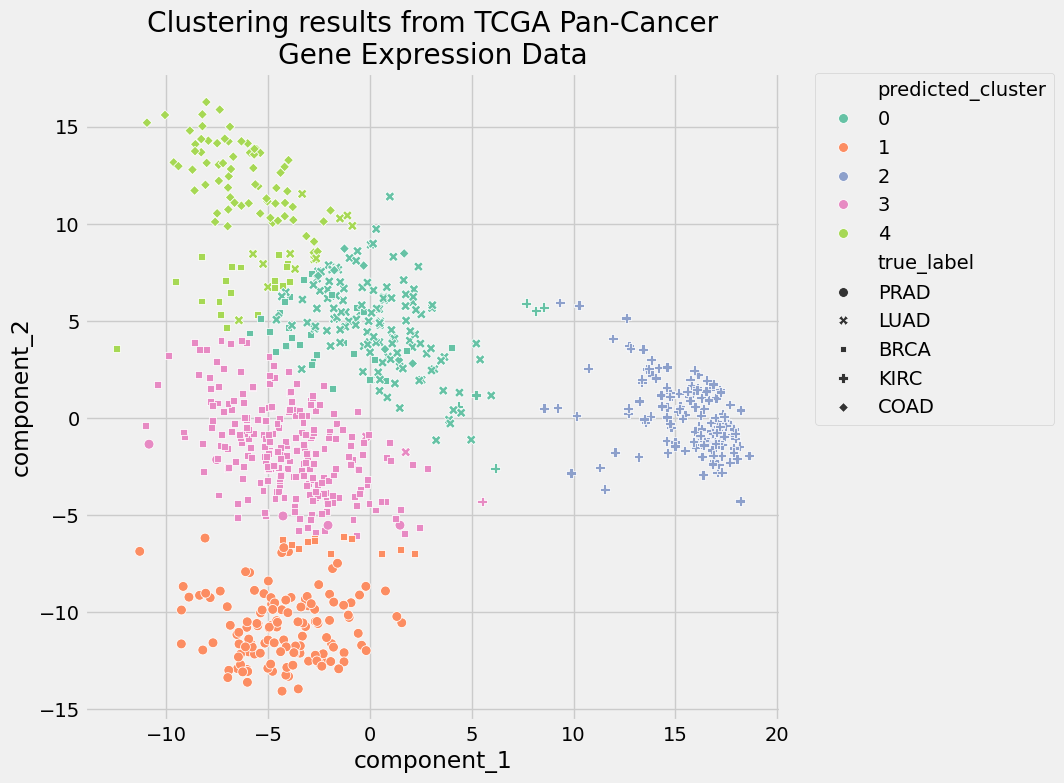

In [ ]:
# Visualize the clustering results
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x="component_1",
    y="component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [ ]:
# Plot silhouette coefficient and ARI scores against the number of components 
# to evaluate clustering performance and visualize how cluster quality changes.
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

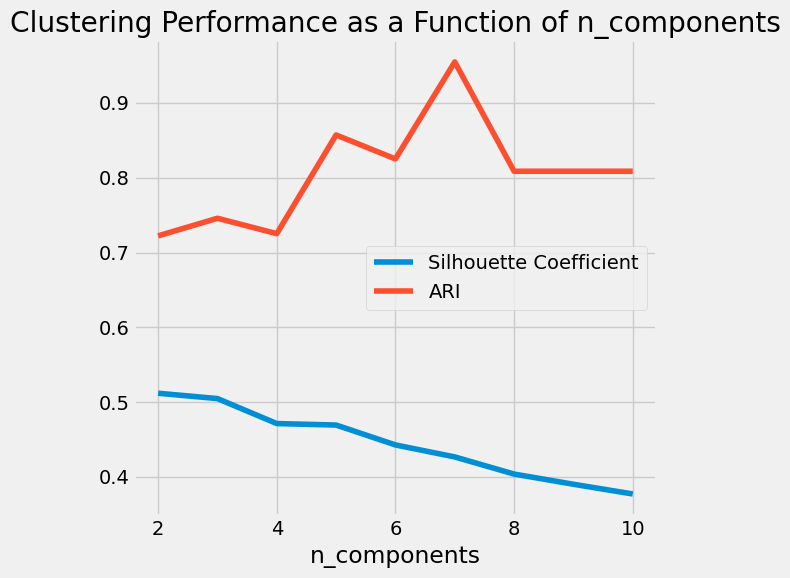

In [18]:
# Plot silhouette coefficient and ARI scores against the number of components 
# to evaluate clustering performance and visualize how cluster quality changes.
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()